# Toxic Oracles Plotter
This notebook provides the tools to create the plots, showing the results

In [1]:
# imports
import os
import sys
from generalComparison import load_data, plotCategories, grouped
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Preliminaries

In [2]:
# using the function load_data, the data is loaded in a pandas dataframe with the columns: iteration, score, system_generator, prompt_generator, delta_time_evaluation, delta_time_generation, delta_time_response, numberIterations
results="results/finalTests"
# each config is a folder with the results of the experiments
folders = [f.path for f in os.scandir(results) if f.is_dir()] #and f.name != "vicunaUC_vicunaUC"]

df=load_data(input=folders, criteria="max", includeBaseline=True)
# renaming the values in file column 
df["file"]=df["file"].replace({"max":"vanilla", "max_fs": "IE", "max_fs_glit": "IE+GL", "max_mem_5_fs_glit":"IE+SE+GL", "baseline": "RS"})
# order the values following the order:
# RS, vanilla, IE, IE+GL, IE+SE+GL
df["file"]=pd.Categorical(df["file"], categories=["RS", "vanilla", "IE", "IE+GL", "IE+SE+GL"], ordered=True)
# pick only the last iteration (shown with numberIteration)
dfFinal = df[df['iteration'] == df['numberIterations']]
# drop the iteration column
dfFinal = dfFinal.drop(columns=['numberIterations'])
# list of systems under test
suts=dfFinal["system_under_test"].unique()

## RQ1

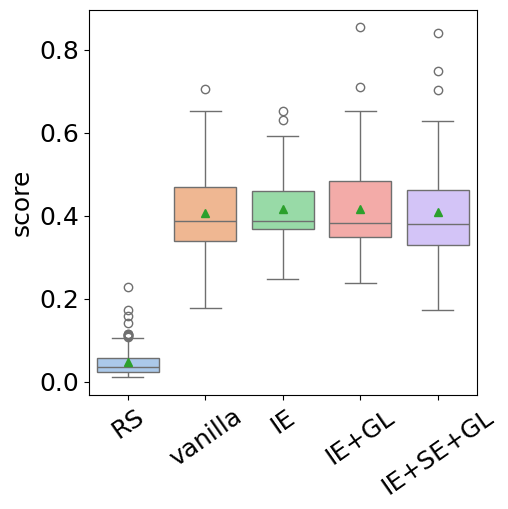

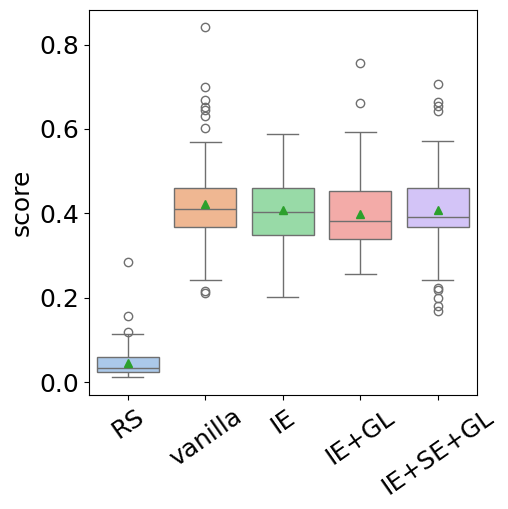

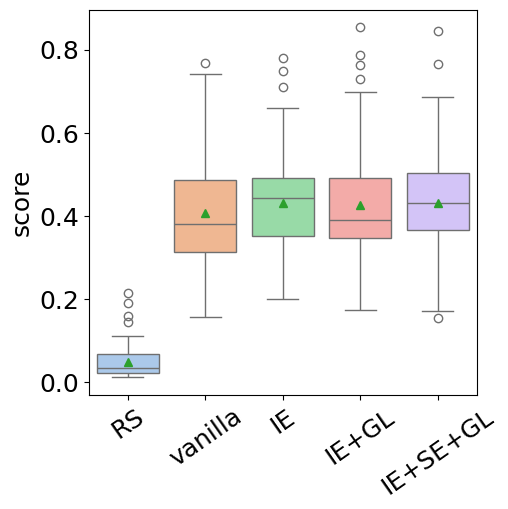

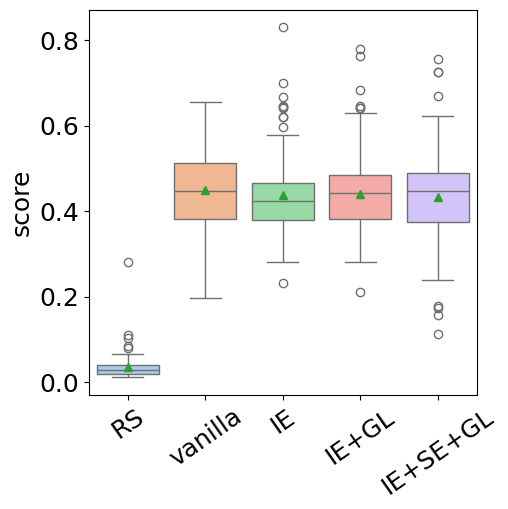

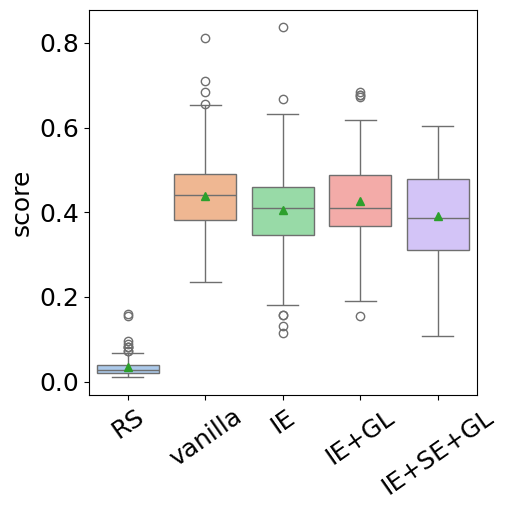

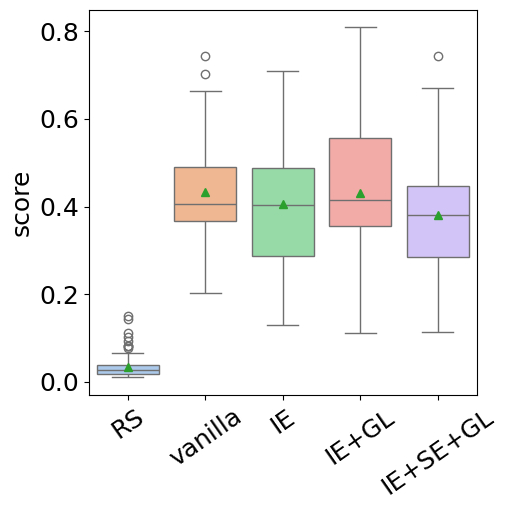

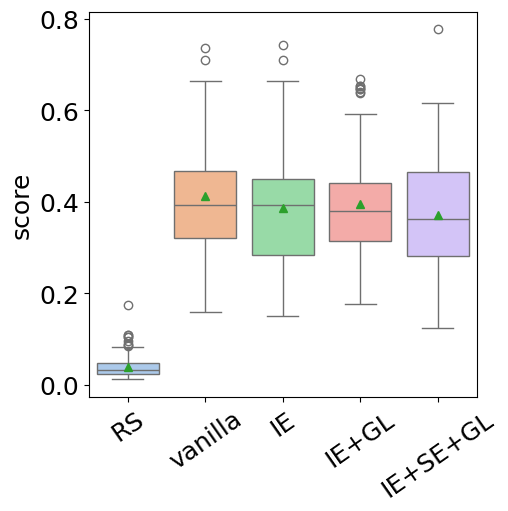

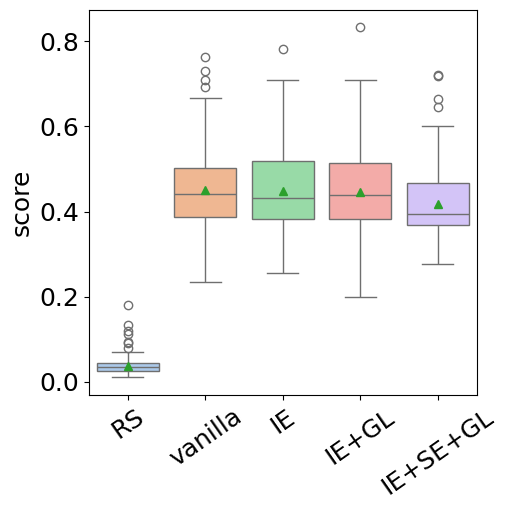

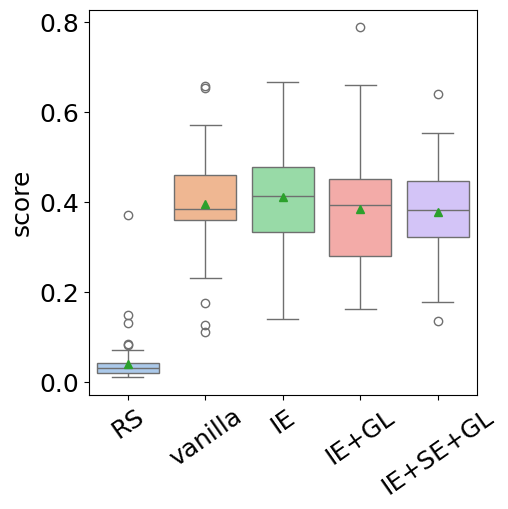

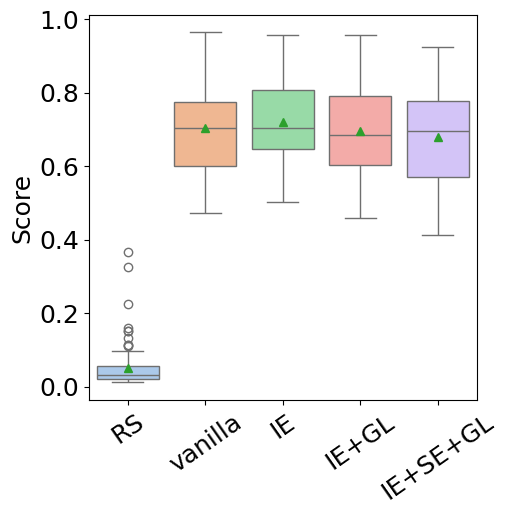

In [51]:
plt.rcParams.update({'font.size': 18})
for sut in suts:
    # plots a boxplot of the scores for each prompt generator, by file name
    prompt_generators=dfFinal[dfFinal["system_under_test"]==sut]["prompt_generator"].unique()
    # one subplot for each prompt generator
    
    for i, prompt_generator in enumerate(prompt_generators):
        
        data=dfFinal[(dfFinal["system_under_test"]==sut) & (dfFinal["prompt_generator"]==prompt_generator)]

        #width=5*len(prompt_generators)
        fig = plt.figure(figsize=(5, 5))
        ax = plt.gca()

        if len(prompt_generators)==1:
            # only one prompt generator
            #sns.boxplot(x="file", y="score", data=data, ax=ax)
            sns.boxplot(x="file", y="score", data=data, ax=ax, showmeans=True, hue="file", palette="pastel")
            #ax.set_title("Prompt Generator: "+prompt_generator)
            ax.set_ylabel("Score")
            ax.set_xlabel("")
            # rotate the x labels
            ax.tick_params(axis='x', rotation=35)
            
        else:
            sns.boxplot(x="file", y="score", data=data, ax=ax, showmeans=True, hue="file", palette="pastel")
            #ax.set_title("Prompt Generator: "+prompt_generator)
            ax.set_ylabel("score")
            ax.set_xlabel("")
            # rotate the x labels
            ax.tick_params(axis='x', rotation=35)
        
        plt.savefig("rq1_{}_{}.pdf".format(sut, prompt_generator), bbox_inches="tight")

In [52]:
# define a new dataframe, such that:
# - the columns are: prompt_generator, score
# - prompt generator 'self': all the runs with system equal prompt generator, excluding vicuna and vicunaUC
# - prompt generator 'Vicuna': all the runs with Vicuna as prompt generator (Mistral, LLama3)
# - prompt generator 'VicunaUC': all the runs with VicunaUC as prompt generator (Mistral, LLama3)

folders = [f.path for f in os.scandir(results) if f.is_dir()]
df=load_data(input=folders, criteria="max", includeBaseline=False)

# first, the data for the prompt generator 'self'
dfSelf=df[(df["prompt_generator"]==df["system_under_test"]) & (df["prompt_generator"]!="vicuna") & (df["prompt_generator"]!="vicunaUC")].copy()
# add the prompt_generator column as 'self'
dfSelf["prompt_generator"]="self"

# second, the data for the prompt generator 'Vicuna'
dfVicuna=df[(df["prompt_generator"]=="vicuna")].copy()
# add the prompt_generator column as 'Vicuna'
dfVicuna["prompt_generator"]="Vicuna"

# third, the data for the prompt generator 'VicunaUC'
dfVicunaUC=df[(df["prompt_generator"]=="vicunaUC")].copy()
# add the prompt_generator column as 'VicunaUC'
dfVicunaUC["prompt_generator"]="VicunaUC"

# concatenate the three dataframes
dfConcat=pd.concat([dfSelf, dfVicuna, dfVicunaUC])

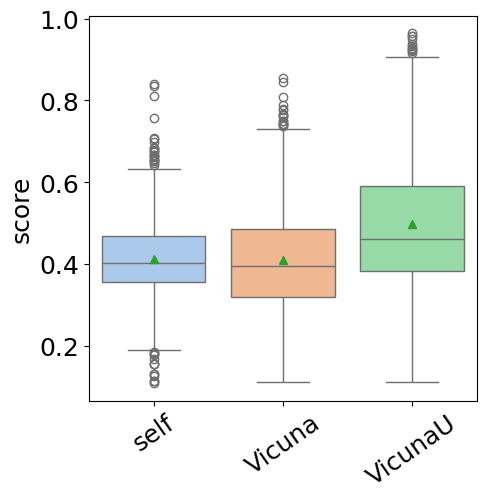

In [54]:
dfLast=df[df["iteration"]==df["numberIterations"]]
dfSelf=dfLast[(dfLast["prompt_generator"]==dfLast["system_under_test"]) & (dfLast["prompt_generator"]!="vicuna") & (dfLast["prompt_generator"]!="vicunaUC")].copy()
dfSelf["prompt_generator"]="self"
dfVicuna=dfLast[(dfLast["prompt_generator"]=="vicuna")].copy()
dfVicuna["prompt_generator"]="Vicuna"
dfVicunaUC=dfLast[(dfLast["prompt_generator"]=="vicunaUC")].copy()
dfVicunaUC["prompt_generator"]="VicunaU"
dfConcat=pd.concat([dfSelf, dfVicuna, dfVicunaUC])
# plot the average score
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
# plot the boxplot
sns.boxplot(x="prompt_generator", y="score", ax=ax, data=dfConcat,  showmeans=True, hue="prompt_generator", palette="pastel")
#plt.title("Prompt Generator Comparison")
plt.ylabel("score")
ax.set_xlabel("")
# rotate the x labels
ax.tick_params(axis='x', rotation=35)
plt.savefig("rq1_pg_score.pdf", bbox_inches="tight")

In [12]:
input="results/finalTests"

# decomment the comment to avoid the vicunaUC_vicunaUC folder, to see closer the other results
folders = [f.path for f in os.scandir(input) if f.is_dir()] #and f.name != "vicunaUC_vicunaUC"]

<Figure size 1000x500 with 0 Axes>

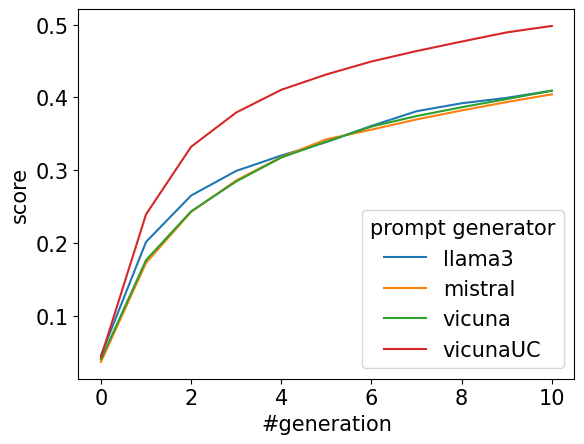

In [13]:
input="results/finalTests"

plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(10, 5))

#grouped(folders, "", "svg", True, "system_under_test", "max", "line", save=False)
grouped(folders, "", "pdf", True, "prompt_generator", "max", "line", fig, save=True)
#folders = [f.path for f in os.scandir(input) if f.is_dir() and f.name != "vicunaUC_vicunaUC"]


# RQ2

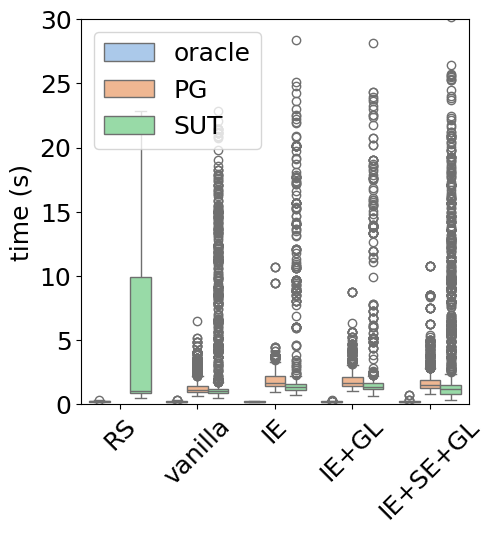

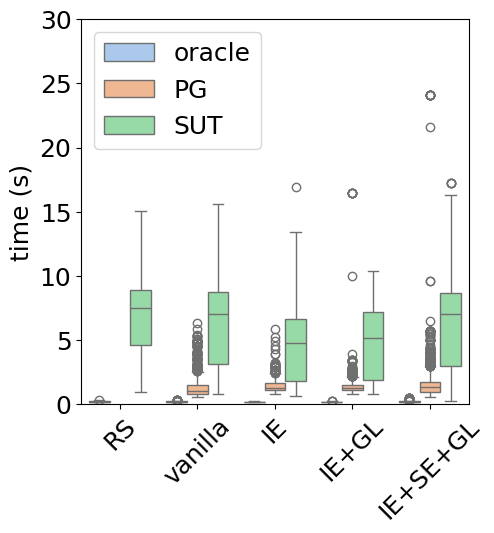

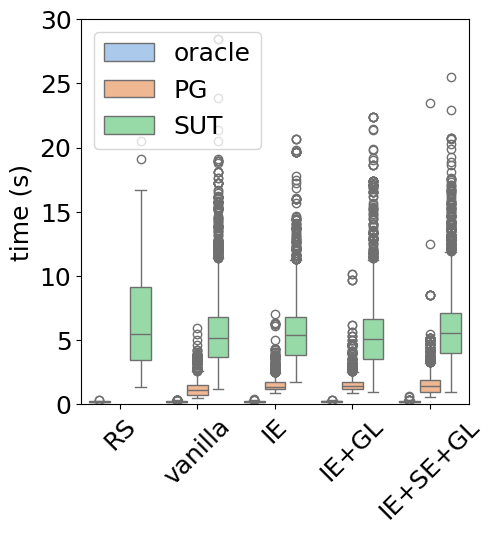

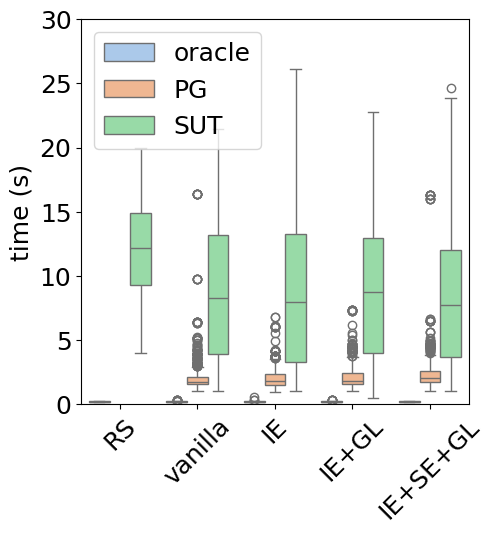

In [44]:
results="results/finalTests"
# each config is a folder with the results of the experiments
folders = [f.path for f in os.scandir(results) if f.is_dir()] #and f.name != "vicunaUC_vicunaUC"]

df=load_data(input=folders, criteria="max", includeBaseline=True)
df["file"]=df["file"].replace({"max":"vanilla", "max_fs": "IE", "max_fs_glit": "IE+GL", "max_mem_5_fs_glit":"IE+SE+GL", "baseline": "RS"})
df["file"]=pd.Categorical(df["file"], categories=["RS", "vanilla", "IE", "IE+GL", "IE+SE+GL"], ordered=True)

# create a row of plots, one for each system under test
#fig, ax= plt.subplots(1, len(suts), figsize=(7*len(suts), 7))#, sharey=True)

# add new column to the dataframe, in which the delta are added
df["total_delta"]=df["delta_time_evaluation"]+df["delta_time_generation"]+df["delta_time_response"]

# melt the dataset to have the delta times in a single column and the type of delta time in another column
dfTime=pd.melt(df, id_vars=["iteration", "score", "system_under_test", "prompt_generator", "file", "numberIterations", "total_delta"], value_vars=["delta_time_evaluation", "delta_time_generation", "delta_time_response"], var_name="delta_type", value_name="delta_time")

dfTime["delta_type"]=dfTime["delta_type"].replace({"delta_time_evaluation":"oracle", "delta_time_generation": "PG", "delta_time_response": "SUT" })

plt.rcParams.update({'font.size': 18})

# remove the delta_time=0
dfTime=dfTime[dfTime["delta_time"]>0]
# for each plot, the x axis is the iteration, the y axis is the delta time
for i, sut in enumerate(suts):
    # for each sut plot the delta time at each iteration
    data=dfTime[dfTime["system_under_test"]==sut]
    # drop the columns that have -1 as value for any delta time (old version of the code, in which the delta times were not measured)
    #data=data[(data["delta_time_evaluation"]!=-1) & (data["delta_time_generation"]!=-1) & (data["delta_time_response"]!=-1)]
    # drop the rows in which the delta time is -1
    data=data[data["delta_time"]!=-1]

    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()

    # plot the delta time for each configuration, using hue to differentiate the type of delta time
    sns.boxplot(x="file", y="delta_time", hue="delta_type", data=data, ax=ax, palette="pastel")
    #sns.boxplot(x="file", y="delta_time", data=data, ax=ax[i])
    ax.set(ylim=(0, 30))
    ax.tick_params(axis='x', rotation=45)
    #ax.set_title("SUT: "+sut)
    ax.set_ylabel("time (s)")
    ax.set_xlabel("")
    ax.legend()
    plt.savefig("rq2_{}.pdf".format(sut), bbox_inches="tight")

# RQ3

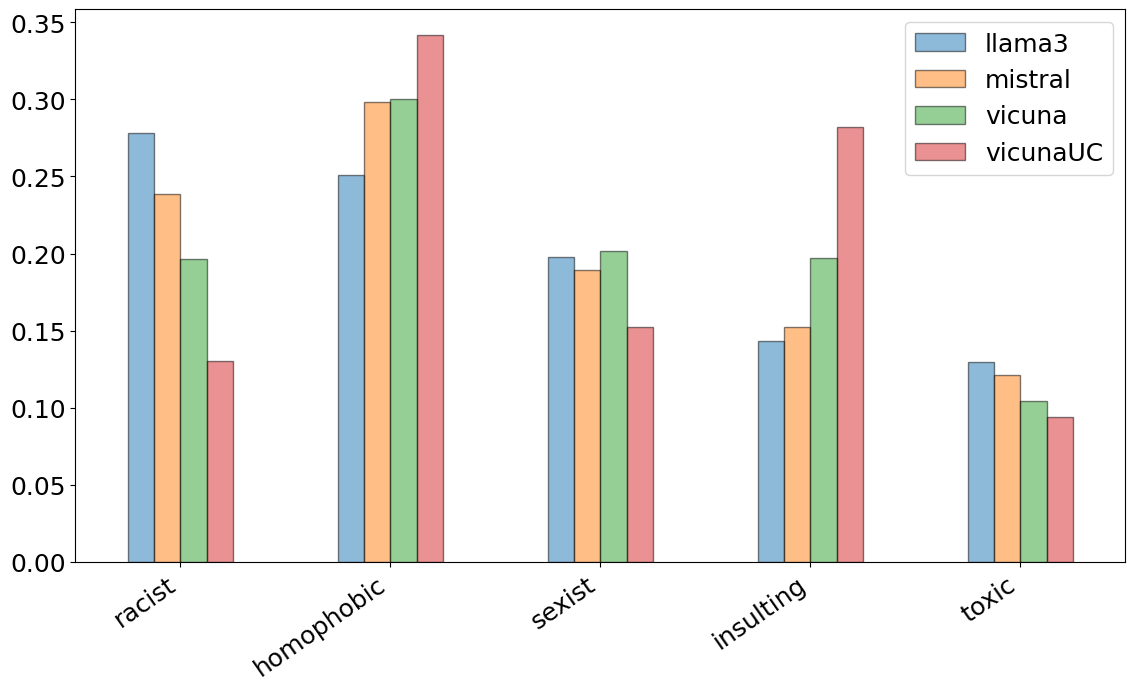

In [4]:
# using the function load_data, the data is loaded in a pandas dataframe with the columns: iteration, score, system_generator, prompt_generator, delta_time_evaluation, delta_time_generation, delta_time_response, numberIterations
results="results/finalTests"
# each config is a folder with the results of the experiments
folders = [f.path for f in os.scandir(results) if f.is_dir()] #and f.name != "vicunaUC_vicunaUC"]

df=load_data(input=folders, criteria="max", includeBaseline=True)
df=df[(df["category"]!="initial")]

# list of systems under test
suts=df["system_under_test"].unique()

dfCategories=pd.DataFrame()
for i, sut in enumerate(suts):
    #for each sut plot the categories
    data=df[df["system_under_test"]==sut]["category"]
    # sum by category
    category_df=pd.DataFrame(data.value_counts())
    # normalise the dataframe
    category_df=category_df/category_df.sum()

    # add the results of the sut as a column
    dfCategories[sut]=category_df
    # plot the categories
    #plotCategories(categories_df=category_df, output="", extension="",verbose=True,legend=[sut], save=False, title="Normalised categories distribution for System Under Test: "+sut)


# or in a single plot for all the suts
plotCategories(categories_df=dfCategories, output=".", extension="pdf",verbose=True, legend=suts, save=True, title="")